In [ ]:
import procaliper as pc
import procaliper.network as pn
import procaliper.view as pcv

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from nglview.color import ColormakerRegistry
from os.path import exists

In [ ]:
fields = pc.Protein.UNIPROT_API_DEFAULT_FIELDS
fields += ["ft_mod_res", "ft_region"]
protein = pc.Protein.from_uniprot_id("P07900")
if exists("P07900.pdb"):
    protein.register_local_pdb(path_to_pdb_file="P07900.pdb")
else:
    print("PDB file not found, fetching from UniProt...")
    protein.fetch_pdb(save_path="P07900.pdb")

Fetched: 1 / 1


In [66]:
color_maker = ColormakerRegistry
protein.get_sasa()  # compute and store sasa values at the site level
assert protein.sasa_data is not None

sasa_scheme = pcv.ngl_scheme(
    protein.sasa_data["all_sasa_value"]
)  # create a color scheme from the sasa values

view = pcv.protein_to_nglview(protein)  # generate an nglview widget

view.stage.set_parameters(
    **{
        # "percentages, "dist" is distance to camera in Angstrom
        "clipNear": 0,
        "clipFar": 100,
        "clipDist": 10,
        # percentages, start of fog and where on full effect
        "fogNear": 0,
        "fogFar": 1000,
        # background color
        "backgroundColor": "black",
    }
)

view._remove_representation()  # remove the default representation

color_maker.add_selection_scheme(
    "all_sasa_value", sasa_scheme
)  # add our color scheme to nglview
view.add_representation(
    "cartoon", color="all_sasa_value"
)  # render the protein using our color scheme

view

NGLWidget()

In [68]:
im = view.render_image()  # adjust the rotation, etc. of the view above before rendering
display(im)

Image(value=b'', width='99%')

In [69]:
with open("scratch.png", "wb") as f:
    f.write(im.value)  # must display image above before saving

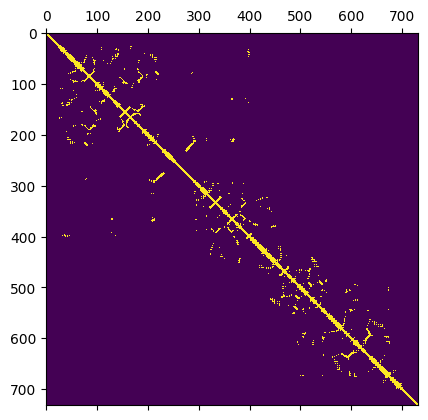

In [3]:
contact_map = nx.to_numpy_array(pn.contact_network(protein))
plt.matshow(contact_map, interpolation="none")
plt.show()

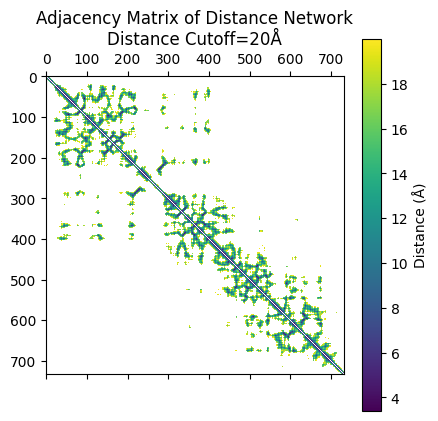

In [4]:
dm = pn.distance_network(
    protein, max_dist_angstroms=20
)  # max_dist_angstroms=20 is the default
plt.matshow(nx.to_numpy_array(dm, nonedge=np.nan), interpolation="none")
plt.colorbar(label="Distance (Å)")
plt.title("Adjacency Matrix of Distance Network\nDistance Cutoff=20Å")
plt.show()

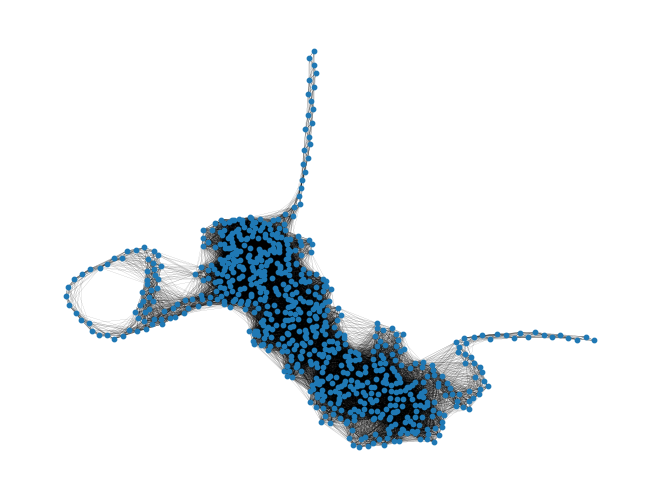

In [64]:
nx.draw(
    dm,
    pos=nx.layout.kamada_kawai_layout(dm),
    node_size=10,
    width=[d["proximity"] for _, _, d in dm.edges(data=True)],
)

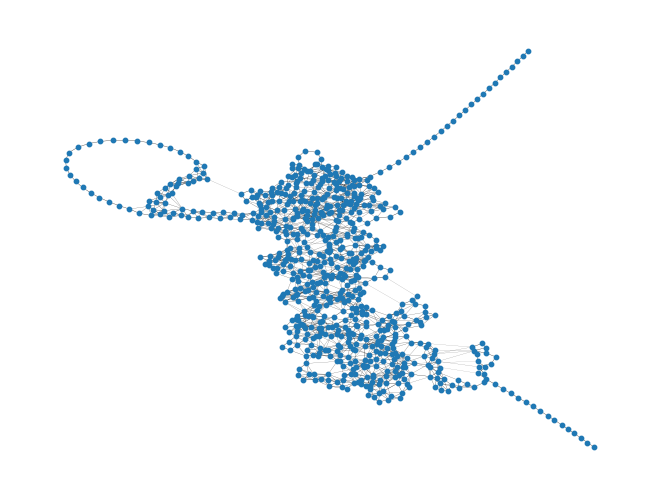

In [65]:
dm_bb = pn.euclidean_backbone(dm)
nx.draw(
    dm_bb,
    pos=nx.layout.kamada_kawai_layout(dm_bb),
    node_size=10,
    width=[d["proximity"] for _, _, d in dm_bb.edges(data=True)],
)

In [5]:
reg = pn.regulatory_distance_network(protein)

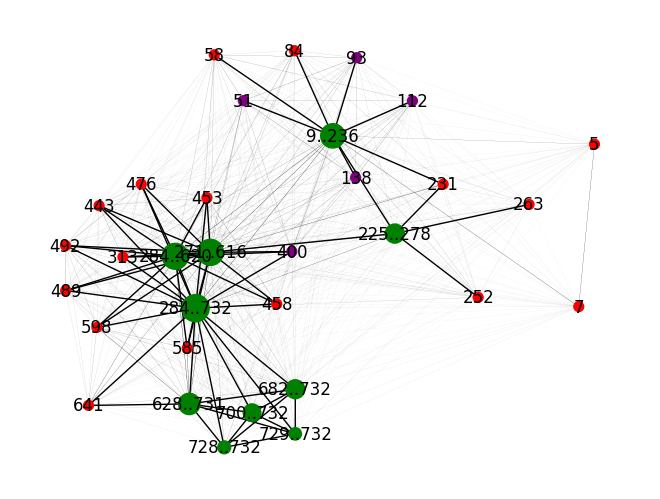

In [63]:
region_type_colors = {
    "PTM site": "red",
    "binding site": "purple",
    "active site": "cyan",
    "annotated region": "green",
}
nx.draw(
    reg,
    pos=nx.layout.spring_layout(
        reg,
        weight="proximity",
        k=10,
        iterations=1000,
        seed=0,
    ),
    node_size=[50 * len(d["residues"]) ** (1 / 3) for _, d in reg.nodes(data=True)],
    width=[d["proximity"] for _, _, d in reg.edges(data=True)],
    labels=nx.get_node_attributes(reg, "label"),
    node_color=[region_type_colors[d["region_type"]] for _, d in reg.nodes(data=True)],
)

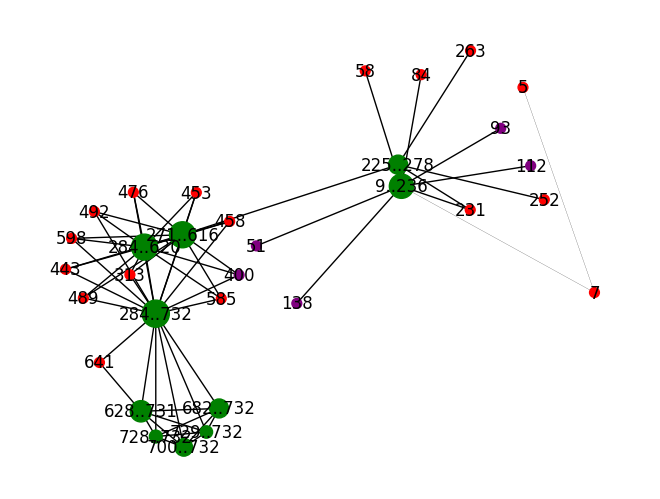

In [62]:
reg_bb = pn.euclidean_backbone(reg)
nx.draw(
    reg_bb,
    pos=nx.layout.spring_layout(
        reg_bb,
        weight="proximity",
        k=10,
        iterations=1000,
        seed=0,
    ),
    node_size=[50 * len(d["residues"]) ** (1 / 3) for _, d in reg_bb.nodes(data=True)],
    width=[d["proximity"] for _, _, d in reg_bb.edges(data=True)],
    labels=nx.get_node_attributes(reg, "label"),
    node_color=[
        region_type_colors[d["region_type"]] for _, d in reg_bb.nodes(data=True)
    ],
)